## Develop Consensus clustering

Put it into clean python file later

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from clustertools.load_data import load_fuzzy_data
from scipy.spatial import distance
from copy import deepcopy
from timeit import default_timer as timer
from datetime import timedelta
import importlib

from clustertools.models import similarity
from clustertools.models import density
from clustertools.models import distance as cl_dist

%matplotlib inline

In [3]:
fuzzy = load_fuzzy_data()
len(fuzzy)

2309

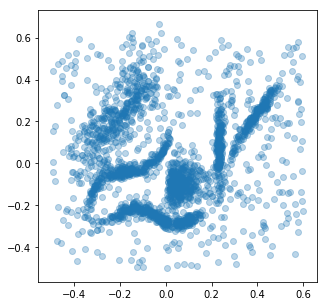

In [4]:
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[:,0], fuzzy[:,1],alpha=.3)

In [28]:
np.random.shuffle(fuzzy)

In [29]:
# Set data

stride = 2
data = fuzzy[::stride]
n = len(data)

Detected 7 clusters
Finished after 0:00:00.099639
Rate of noise in dataset: 0.293506


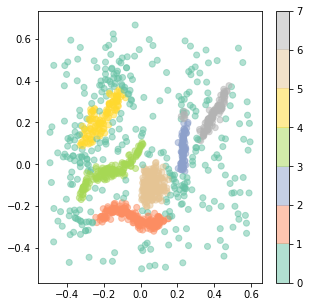

In [30]:
dbscan_obj = density.DBSCAN(data, eps=0.03, minPts=10)
dbscan_obj.fit()
labels = dbscan_obj.cluster_labels
#print((labels[:] == 'noise'))
for i in range(len(labels)):
    if labels[i] == 'noise':
        labels[i] = 0
#labels[[i for i in range(len(labels)) if labels[i] == 'noise']] = 0
#print(labels)
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', dbscan_obj._n_clusters), alpha=.5)
plt.colorbar()

terminated by break condition
44 iterations until termination.
Finished after 0:00:00.046301
max within-cluster distance to center: 0.344241
mean within-cluster distance to center: 0.084887
sum of within cluster squared errors: 11.872828


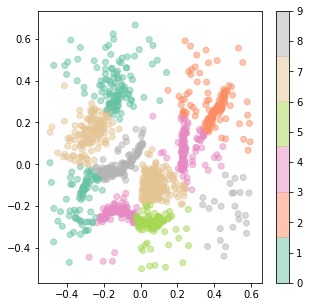

In [31]:
kmeans_obj = cl_dist.KMeans(data, 10)
kmeans_obj.fit()
labels = kmeans_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Hierarchical clustering terminated.
Finished after 0:00:05.494444
Stopping cluster number was reached.
Current number of clusters: 10
Current minimum cluster distance: 0.27


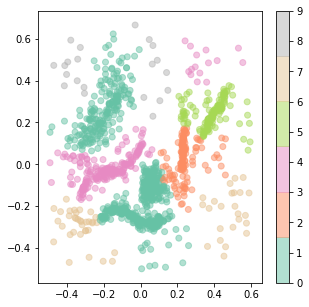

In [32]:
hiercl_obj = similarity.HierarchicalClustering(data, k=10)
hiercl_obj.fit()
labels = hiercl_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

Constructing gaussian similarity matrix
Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
11 iterations until termination.
Finished after 0:00:00.034655
max within-cluster distance to center: 0.610702
mean within-cluster distance to center: 0.062368
sum of within cluster squared errors: 7.515268
KMeans terminated. 

Finished after 0:00:13.029279


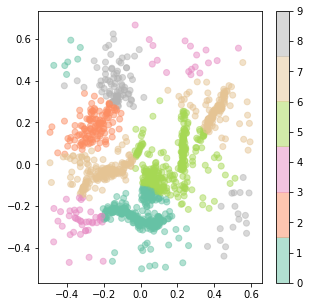

In [37]:
spectral_obj = similarity.SpectralClustering(data, n=10, bandwidth=0.1)
spectral_obj.fit()
labels = spectral_obj.cluster_labels
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

In [61]:
def fit(clusterings, k=5, recluster_what='clusters', how='spectral', **kwargs):
    
    # n: number of data points, that are clustered by different algorithms
    
    # TODO:
    # docstring
    # setze verbose auf verbose
    
    m = len(clusterings)
    assert m > 0, "the list of fitted clustering objects is empty"
    assert any((recluster_what == 'clusters', recluster_what == 'points')), "unknown recluster_what-parameter"
    assert any((how == 'spectral', how == 'hierarchical')), "unknown how-parameter"
    n = len(clusterings[0].cluster_labels)
    assert all(tuple([len(clustering.cluster_labels) == n for clustering in clusterings])), "clusterings did not cluster same amount of points"
    
    # Create array of labels
    labels = np.zeros((n, m)).astype(int)
    num_unique_labels = np.zeros(m).astype(int)
    for j in range(m):
        labels[:, j] = clusterings[j].cluster_labels
        num_unique_labels[j] = len(np.unique(clusterings[j].cluster_labels))
    num_edges = None
    hypergraph = None
    
    # Possibly create hypergraph
    if recluster_what == 'clusters':
        num_edges = np.sum(num_unique_labels).astype(int)
        hypergraph = np.zeros((num_edges, n)).astype(int)
        cluster_sum = 0
        for j in range(m): # for all clusterings
            for l in range(num_unique_labels[j]): # for all cluster labels
                hypergraph[cluster_sum + l, :] = (labels[:, j] == l)
            cluster_sum += num_unique_labels[j]
    
    # Calculate distance matrix of hyperedges or points
    if recluster_what == 'clusters':
        dists = distance.squareform(distance.pdist(hypergraph, 'jaccard'))
    elif recluster_what == 'points':
        dists = distance.squareform(distance.pdist(labels, 'hamming'))
    
    # Recluster
    meta_clustering = None
    if how == 'hierarchical':
        meta_clustering = similarity.HierarchicalClustering(dists, metric=None, k=k)
    if how == 'spectral':
        meta_clustering = similarity.SpectralClustering(dists, similarity_measure=None, n=k)
    meta_clustering.fit()
    meta_labels = meta_clustering.cluster_labels
    
    # Possibly for points
    cluster_labels = np.zeros(n).astype(int)
    if recluster_what == 'points':
        cluster_labels = meta_labels
    if recluster_what == 'clusters':
        point_label_buckets = np.zeros((n, k)).astype(int)
        for edge_ind in range(num_edges):
            point_label_buckets[:, meta_labels[edge_ind]] += hypergraph[edge_ind]
        for i in range(n):
            cluster_labels[i] = np.random.choice(np.flatnonzero(point_label_buckets[i, :] == point_label_buckets[i, :].max()))
        
    return cluster_labels

In [62]:
# Set some parameters

stride = 2
data = fuzzy[::stride]
n = len(data)

#clusterings = [kmeans_obj, kmeans_obj]
#clusterings = [hiercl_obj, hiercl_obj]
#clusterings = [kmeans_obj, dbscan_obj]
clusterings = [spectral_obj, dbscan_obj, kmeans_obj, hiercl_obj]
recluster_what = 'clusters'
#recluster_what = 'points'
#how = 'hierarchical'
how = 'spectral'
k = 8 # how many clusters to produce

Computing generalized Laplacian eigenproblem


KMeans initialization on eigenvectors...
terminated by break condition
1 iterations until termination.
Finished after 0:00:00.022512
max within-cluster distance to center: 16.518335
mean within-cluster distance to center: 5.315810
sum of within cluster squared errors: 2028.199310
KMeans terminated. 

Finished after 0:00:00.029139


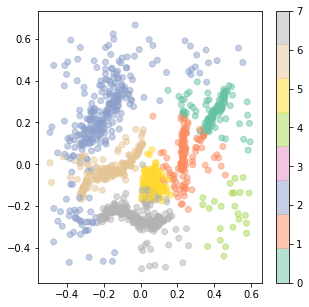

In [63]:
labels = fit(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how) # kwargs-handling noch
plt.figure(figsize=(5, 5))
plt.scatter(fuzzy[::stride,0], fuzzy[::stride,1], c=labels, cmap=plt.get_cmap('Set2', k), alpha=.5)
plt.colorbar()

In [57]:
np.flatnonzero(np.array([0, 0, 0, 1, 0, 0, 1, 1]))

array([3, 6, 7], dtype=int64)

In [55]:
np.random.choice([0, 2, 5])

0

In [26]:
test = np.array([[0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1]])
test2 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 1, 0, 0, 1, 1]])
test3 = np.array([[0, 0, 0, 1, 1, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1, 1]])
print(test)
print(test2)
print(test3)
print(distance.squareform(distance.pdist(test, 'jaccard')))
print(distance.squareform(distance.pdist(test2, 'jaccard')))
print(distance.squareform(distance.pdist(test3, 'jaccard')))

[[0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]]
[[0 0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[ 0.   0.4]
 [ 0.4  0. ]]
[[ 0.   0.6]
 [ 0.6  0. ]]
[[ 0.  0.]
 [ 0.  0.]]


In [21]:
test = np.array([[0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1, 1, 1]])
test2 = np.array([[0, 0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 0, 1, 0, 0, 1, 1]])
test3 = np.array([[0, 0, 0, 1, 1, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1, 1]])
test4 = np.array([[0, 2, 2, 1, 1, 1, 1, 1],
                  [0, 2, 3, 1, 1, 1, 1, 1]])
print(test)
print(test2)
print(test3)
print(distance.squareform(distance.pdist(test, 'hamming')))
print(distance.squareform(distance.pdist(test2, 'hamming')))
print(distance.squareform(distance.pdist(test3, 'hamming')))
print(distance.squareform(distance.pdist(test4, 'hamming')))

[[0 0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]]
[[0 0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]]
[[ 0.    0.25]
 [ 0.25  0.  ]]
[[ 0.     0.375]
 [ 0.375  0.   ]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.     0.125]
 [ 0.125  0.   ]]


In [22]:
1 - np.arange(4).reshape((2, 2))

array([[ 1,  0],
       [-1, -2]])

In [23]:
np.arange(4)

array([0, 1, 2, 3])